In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Lambda

In [3]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)


In [4]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])


In [5]:
# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='Variational-Auto-Encoder')


In [6]:
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 184.9587 - val_loss: 167.5193
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 166.0365 - val_loss: 165.0855
Epoch 3/100
1875/1875 [==============================] - 8s 4ms/step - loss: 163.0022 - val_loss: 162.0160
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 160.3899 - val_loss: 159.6902
Epoch 5/100
1875/1875 [==============================] - 7s 4ms/step - loss: 158.5526 - val_loss: 158.2260
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 157.3043 - val_loss: 157.1190
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 156.2845 - val_loss: 156.0867
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 155.4291 - val_loss: 155.6434
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 154.6795 - val_loss: 154.9554
Epoch 10/100
1875/1875 [=============

In [9]:
x_test_encoded = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


TypeError: ignored

<Figure size 432x432 with 0 Axes>

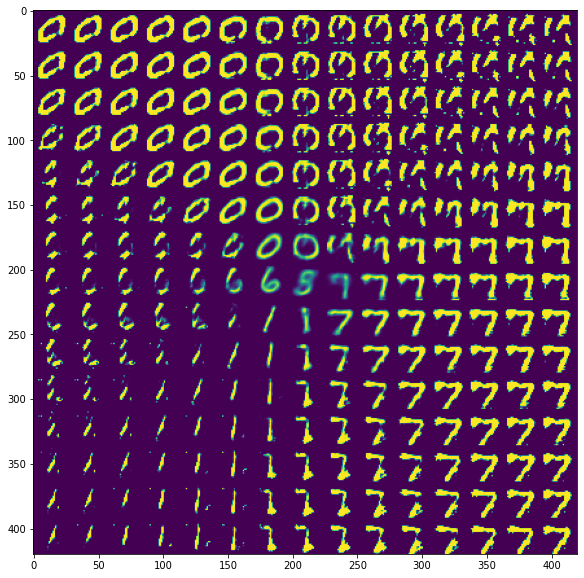

In [10]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
